# Copyright Netherlands eScience Center <br>
** Function     : Visualization of AMET and OMET from reanalysis datasets ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.04.06 ** <br>
** Last Update  : 2019.04.06 ** <br>
Description     : The code aims to compare the oceanic meridional energy transport
                  calculated from different oceanic reanalysis datasets. In this,
                  case, this includes GLORYS2V3 from Mercator Ocean, ORAS4 from ECMWF,
                  and SODA3 from University of Maryland & TAMU.<br>

Return Value    : NetCFD4 data file<br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib, logging<br>
variables       : OMET               Tera Watt <br>
Caveat!!        : Resolution

                  GLORYS2V3   1993 - 2014
                  ORAS4       1958 - 2014
                  SODA3       1980 - 2015
                  NEMO ORCA   1979 - 2012
                  
                  MOM5 Grid
                  Direction of Axis: from south to north, west to east
                  Model Level: MOM5 Arakawa-B grid
                  Dimension:
                  Latitude      1070
                  Longitude     1440
                  Depth         50
                  
                  ORCA1 Grid
                  Direction of Axis: from south to north, west to east
                  Model Level: ORCA Arakawa-C grid
                  Dimension:
                  Latitude      362
                  Longitude     292
                  Depth         42
                  
                  ORCA025 Grid
                  Direction of Axis: from south to north, west to east
                  Model Level: ORCA Arakawa-C grid
                  Dimension:
                  Latitude      1021
                  Longitude     1440
                  Depth         75

                  ORCA083 Grid
                  Direction of Axis: from south to north, west to east
                  Model Level: ORCA Arakawa-C grid
                  Dimension:
                  Latitude      1565
                  Longitude     4322
                  Depth         75

                  The mask might have filled value of 1E+20 (in order to maintain
                  the size of the netCDF file and make full use of the storage). When
                  take the mean of intergral, this could result in abnormal large results.
                  With an aim to avoid this problem, it is important to re-set the filled
                  value to be 0 and then take the array with filled value during calculation.
                  (use "masked_array.filled()")

In [1]:
import numpy as np
import seaborn as sns
#import scipy as sp
import time as tttt
from netCDF4 import Dataset,num2date
import os
import platform
import sys
import logging
# package for plot
import matplotlib
# generate images without having a window appear
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.path as mpath
#from mpl_toolkits.basemap import Basemap, cm
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import iris
import iris.plot as iplt
import iris.quickplot as qplt

In [2]:
# specify data path
datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4/postprocessing'
datapath_GLORYS2V3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3/postprocessing'
datapath_SODA3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3/postprocessing'

maskpath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ORAS4'
maskpath_GLORYS2V3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/GLORYS2V3'
maskpath_SODA3 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/SODA3'
# specify output path
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/ESD/figures'

/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/iris/__init__.py:237: IrisDeprecation: setting the 'Future' property 'netcdf_promote' is deprecated and will be removed in a future release. Please remove code that sets this property.
  warn_deprecated(msg.format(name))
/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/iris/analysis/cartography.py:614: UserWarning: Coordinate system of latitude and longitude coordinates is not specified. Assuming WGS84 Geodetic.
  warnings.warn('Coordinate system of latitude and longitude '
/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous boun

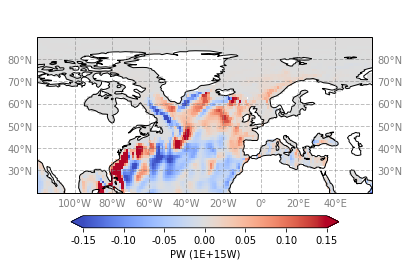

/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


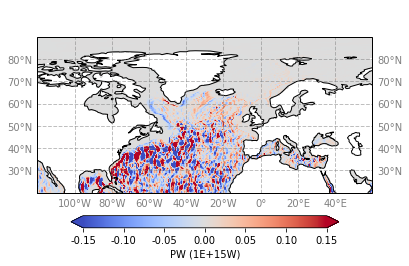

/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'projection_x_coordinate' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'projection_y_coordinate' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))


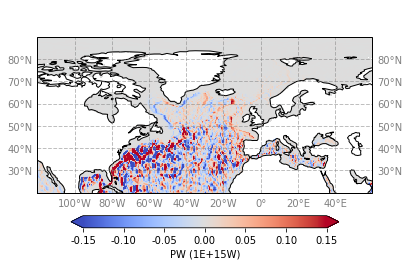

In [3]:
#*******************************************************************
#*********************** extract variables *************************
#*******************************************************************
# data
dataset_ORAS4 = Dataset(datapath_ORAS4 + os.sep + 'oras4_model_monthly_orca1_E_point.nc')
dataset_GLORYS2V3 = Dataset(datapath_GLORYS2V3 + os.sep + 'GLORYS2V3_model_monthly_orca025_E_point.nc')
dataset_SODA3 = Dataset(datapath_SODA3 + os.sep + 'OMET_SODA3_model_5daily_1980_2015_E_point.nc')
# mesh and mask
mesh_mask_ORAS4 = Dataset(maskpath_ORAS4 + os.sep + 'mesh_mask.nc')
mesh_mask_GLORYS2V3 = Dataset(maskpath_GLORYS2V3 + os.sep + 'G2V3_mesh_mask_myocean.nc')
mesh_mask_SODA3 = Dataset(maskpath_SODA3 + os.sep + 'topog.nc')
# from 20N - 90N
OMET_ORAS4 = dataset_ORAS4.variables['E'][21:,:,180:,:]/1000 # start from 1979
OMET_GLORYS2V3 = dataset_GLORYS2V3.variables['E'][:,:,579:,:]/1000 # start from 1993
OMET_SODA3 = dataset_SODA3.variables['E'][:,:,569:,:]/1000 # start from 1993
#mask (surface mask only)
vmask_ORAS4 = mesh_mask_ORAS4.variables['vmask'][0,0,180:,:] # from 20N
vmask_GLORYS2V3 = mesh_mask_GLORYS2V3.variables['vmask'][0,0,579:,:] # from 20N
vmask_SODA3 = mesh_mask_SODA3.variables['wet_c'][569:,:] # from 20N
# year
year_ORAS4 = dataset_ORAS4.variables['year'][21:]         # from 1958 to 2014
year_GLORYS2V3 = dataset_GLORYS2V3.variables['year'][:]   # from 1993 to 2014
year_SODA3 = dataset_SODA3.variables['year'][:]           # from 1980 to 2015

latitude_ORAS4 = dataset_ORAS4.variables['latitude'][180:,:]
latitude_GLORYS2V3 = dataset_GLORYS2V3.variables['latitude'][579:,:]
latitude_SODA3 = dataset_SODA3.variables['latitude'][569:,:]

longitude_ORAS4 = dataset_ORAS4.variables['longitude'][180:,:]
longitude_GLORYS2V3 = dataset_GLORYS2V3.variables['longitude'][579:,:]
longitude_SODA3 = dataset_SODA3.variables['longitude'][569:,:]
#*******************************************************************
#************************** maps factory ***************************
#*******************************************************************
# The visualization of AMET and OMET are complete with Iris and Cartopy.

# support NetCDF
iris.FUTURE.netcdf_promote = True

# ========================  ORAS4  ========================
# ORAS4 only
# use Iris for interpolation/regridding
# create cube for plot in an elegant way

# mask the array
OMET_ORAS4_mask = np.ma.masked_where(vmask_ORAS4 == 0, OMET_ORAS4[17,0,:,:])

# choose interpolation method
method_int = 2 # ! 1 = bilinear interpolation ! 2 = nearest neghbour interpolation
if method_int == 1:
    # prepare the cube
    latitude_OMET_ORAS4 = iris.coords.AuxCoord(latitude_ORAS4,standard_name='latitude',units='degrees')
    longitude_OMET_ORAS4 = iris.coords.AuxCoord(longitude_ORAS4,standard_name='longitude',units='degrees')
    cube_ORAS4 = iris.cube.Cube(OMET_ORAS4_mask,long_name='Oceanic Meridional Energy Transport', var_name='OMET',units='PW',
                              aux_coords_and_dims=[(latitude_OMET_ORAS4,(0,1)),(longitude_OMET_ORAS4,(0,1))])
    # choose the coordinate system for Cube (for regrid module)
    coord_sys = iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS)
    # Feed cube with coordinate system
    cube_ORAS4.coord('latitude').coord_system = coord_sys
    cube_ORAS4.coord('longitude').coord_system = coord_sys
    #print cube_ORAS4
    # create grid_cube for regridding, this is a dummy cube with desired grid
    lat_grid = np.linspace(20, 90, 71)
    lon_grid = np.linspace(-180, 180, 361)
    # interpolate_points = [('latitude', np.linspace(-90, 90, 181)),
    #                       ('longitude', np.linspace(-180, 181, 361))]
    lat_aux = iris.coords.DimCoord(lat_grid, standard_name='latitude',
                                   units='degrees_north', coord_system='GeogCS')
    lon_aux = iris.coords.DimCoord(lon_grid, standard_name='longitude',
                                   units='degrees_east', coord_system='GeogCS')
    dummy_data = np.zeros((len(lat_grid), len(lon_grid)))
    aux_cube = iris.cube.Cube(dummy_data,dim_coords_and_dims=[(lat_aux, 0), (lon_aux, 1)])
    # Feed cube with coordinate system
    aux_cube.coord('latitude').guess_bounds()
    aux_cube.coord('longitude').guess_bounds()
    aux_cube.coord('latitude').coord_system = coord_sys
    aux_cube.coord('longitude').coord_system = coord_sys
    # create a weight matrix for regridding
    weights = np.ones(cube_ORAS4.shape)
    # interpolate from ORCA grid to rectilinear grid through bilinear interpolation
    # The method uses point in cell interpolation and then perform the bilinear interpolation
    # based on distance and weight
    cube_ORAS4_regrid = iris.experimental.regrid.regrid_weighted_curvilinear_to_rectilinear(cube_ORAS4,weights,aux_cube)
else:
    # define the cube for the use of iris package
    latitude_OMET_ORAS4 = iris.coords.AuxCoord(latitude_ORAS4,standard_name='latitude',units='degrees')
    longitude_OMET_ORAS4 = iris.coords.AuxCoord(longitude_ORAS4,standard_name='longitude',units='degrees')
    cube_ORAS4 = iris.cube.Cube(OMET_ORAS4_mask,long_name='Oceanic Meridional Energy Transport',
                            var_name='OMET',units='PW',aux_coords_and_dims=[(latitude_OMET_ORAS4,(0,1)),(longitude_OMET_ORAS4,(0,1))])
    #print cube_ORAS4
    # Transform cube to target projection
    cube_ORAS4_regrid, extent = iris.analysis.cartography.project(cube_ORAS4, ccrs.PlateCarree(), nx=720, ny=140)
    # interpolation complete!!
    #print cube_ORAS4_regrid


#print 'PlateCarree'

# figsize works for the size of the map, not the entire figure
fig8 = plt.figure(figsize=(6,4.2))
fig8.suptitle(' ',fontsize = 10,y=0.93)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-120,60,20,90],ccrs.PlateCarree()) # East, West, South, Nouthpse
ax.set_aspect('1.2')
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5,linestyle='--')
gl.xlabels_top = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = {'size': 10, 'color': 'gray'}

cs = iplt.pcolormesh(cube_ORAS4_regrid,cmap='coolwarm',vmin=-0.15,vmax=0.15)
cbar = fig8.colorbar(cs,extend='both',orientation='horizontal',shrink =0.8,pad=0.1,format="%.2f")
cbar.set_ticks([-0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15])
cbar.ax.tick_params(labelsize = 10)
cbar.set_label('PW (1E+15W)',size = 10)
# show and save plot
iplt.show()
fig8.savefig(output_path + os.sep + 'ORAS4_PlateCarree_Jan1996.png',dpi = 300)
plt.close(fig8)

#print '========================  GLORYS2v3  ========================'
# use Iris for interpolation/regridding
# create cube for plot in an elegant way

# mask the array
OMET_GLORYS2V3_mask = np.ma.masked_where(vmask_GLORYS2V3 == 0, OMET_GLORYS2V3[3,0,:,:])
np.ma.set_fill_value(OMET_GLORYS2V3_mask,0) # change the filled value to 0
# define the cube for the use of iris package
latitude_OMET_GLORYS2V3 = iris.coords.AuxCoord(latitude_GLORYS2V3,standard_name='latitude',units='degrees')
longitude_OMET_GLORYS2V3 = iris.coords.AuxCoord(longitude_GLORYS2V3,standard_name='longitude',units='degrees')
cube_GLORYS2V3 = iris.cube.Cube(OMET_GLORYS2V3_mask,long_name='Oceanic Meridional Energy Transport',
                                var_name='OMET',units='PW',aux_coords_and_dims=[(latitude_OMET_GLORYS2V3,(0,1)),(longitude_OMET_GLORYS2V3,(0,1))])
coord_sys = iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS)
cube_GLORYS2V3.coord('latitude').coord_system = coord_sys
cube_GLORYS2V3.coord('longitude').coord_system = coord_sys
# Transform cube to target projection
cube_GLORYS2V3_regrid, extent = iris.analysis.cartography.project(cube_GLORYS2V3, ccrs.PlateCarree(), nx=1440, ny=350)
# interpolation complete!!
#print cube_GLORYS2V3_regrid

#print 'PlateCarree'

# figsize works for the size of the map, not the entire figure
fig10 = plt.figure(figsize=(6,4.2))
fig10.suptitle(' ',fontsize = 10,y=0.93)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-120,60,20,90],ccrs.PlateCarree()) # East, West, South, Nouthpse
ax.set_aspect('1.2')
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5,linestyle='--')
gl.xlabels_top = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = {'size': 10, 'color': 'gray'}
cs = iplt.pcolormesh(cube_GLORYS2V3_regrid,cmap='coolwarm',vmin=-0.15,vmax=0.15)
cbar = fig10.colorbar(cs,extend='both',orientation='horizontal',shrink =0.8,pad=0.1,format="%.2f")
cbar.set_ticks([-0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15])
cbar.ax.tick_params(labelsize = 10)
cbar.set_label('PW (1E+15W)',size = 10)
# show and save plot
iplt.show()
fig10.savefig(output_path + os.sep + 'GLORYS2V3_PlateCarree_Jan1996.png',dpi = 300)
plt.close(fig10)

#print '========================  SODA3  ========================'

# use Iris for interpolation/regridding
# create cube for plot in an elegant way

# mask the array
OMET_SODA3_mask = np.ma.masked_where(vmask_SODA3 == 0, OMET_SODA3[16,0,:,:])
np.ma.set_fill_value(OMET_SODA3_mask,0) # change the filled value to 0
# define the cube for the use of iris package
latitude_OMET_SODA3 = iris.coords.AuxCoord(latitude_SODA3,standard_name='latitude',units='degrees')
longitude_OMET_SODA3 = iris.coords.AuxCoord(longitude_SODA3,standard_name='longitude',units='degrees')
cube_SODA3 = iris.cube.Cube(OMET_SODA3_mask,long_name='Oceanic Meridional Energy Transport',
                                var_name='OMET',units='PW',aux_coords_and_dims=[(latitude_OMET_SODA3,(0,1)),(longitude_OMET_SODA3,(0,1))])
coord_sys = iris.coord_systems.GeogCS(iris.fileformats.pp.EARTH_RADIUS)
cube_SODA3.coord('latitude').coord_system = coord_sys
cube_SODA3.coord('longitude').coord_system = coord_sys
# Transform cube to target projection
cube_SODA3_regrid, extent = iris.analysis.cartography.project(cube_SODA3, ccrs.PlateCarree(), nx=1440, ny=350)
# interpolation complete!!
#print cube_SODA3_regrid

#print 'PlateCarree'

# figsize works for the size of the map, not the entire figure
fig12 = plt.figure(figsize=(6,4.2))
fig12.suptitle(' ',fontsize = 10,y=0.93)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-120,60,20,90],ccrs.PlateCarree()) # East, West, South, Nouthpse
ax.set_aspect('1.2')
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5,linestyle='--')
gl.xlabels_top = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'gray'}
gl.ylabel_style = {'size': 10, 'color': 'gray'}

cs = iplt.pcolormesh(cube_SODA3_regrid,cmap='coolwarm',vmin=-0.15,vmax=0.15)
cbar = fig12.colorbar(cs,extend='both',orientation='horizontal',shrink =0.8,pad=0.1,format="%.2f")
cbar.set_ticks([-0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15])
cbar.ax.tick_params(labelsize = 10)
cbar.set_label('PW (1E+15W)',size = 10)
# show and save plot
iplt.show()
fig12.savefig(output_path + os.sep + 'SODA3_PlateCarree_Jan1996.png',dpi = 300)
plt.close(fig12)